### 과제 2: 배송 성과 분석
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요



## EDA 진행 
**목표:** 지역별 배송 시간의 평균과 분포를 확인하고, 배송 시간과 고객 리뷰 점수 간의 관계를 파악합니다.

### **분석 로직:**

1. **날짜/시간 변환**: `orders` 데이터셋의 `order_purchase_timestamp`와 `order_delivered_customer_date`를 `datetime` 타입으로 변환합니다.
2. **배송 시간 계산**: `order_delivered_customer_date`에서 `order_purchase_timestamp`를 빼서 배송 소요 시간을 계산합니다.
3. **데이터 병합**: `orders`와 `geolocation` 데이터셋을 병합하여 주문별 지역 정보를 추가합니다. 또한, `orders`와 `reviews` 데이터셋을 병합하여 주문별 리뷰 점수를 연결합니다.
4. **지역별 분석**: `customer_state`를 기준으로 그룹화하여 지역별 평균 배송 시간을 계산합니다.
5. **상관관계 분석**: 배송 소요 시간과 `review_score` 간의 상관계수를 계산합니다.

### **시각화 계획:**

- **박스플롯**: 지역별(주/도시) 배송 시간의 분포를 한눈에 비교하기 위해 박스플롯을 그립니다.
- **산점도**: 배송 소요 시간과 리뷰 점수 간의 관계를 시각적으로 확인하기 위해 산점도를 그립니다.
- **히스토그램**: 리뷰 점수별(1~5점) 배송 소요 시간의 분포를 비교하는 히스토그램을 그립니다.


오늘 진행할 내용은  
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석 




# 데이터 전처리 코드 

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 주요 테이블 로딩

customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
category_name = pd.read_csv("product_category_name_translation.csv")
geolocation= pd.read_csv("olist_geolocation_dataset.csv")


### 데이터 형 변환 (포르투갈어-> 영어, date_time 형식으로 변환)

In [2]:
# 각 데이터셋 크기 확인
datasets = {
    "customers": customers,
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "sellers": sellers,
    "payments": payments,
    "reviews": reviews,
    "category_name": category_name,
    "geolocation": geolocation
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")
    display(df.head(2))  # 앞부분 2행만 미리보기


# ======================
# [1] Products 카테고리명 번역 (포르투갈어 → 영어)
# ======================
products = pd.read_csv("olist_products_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# 병합 후 컬럼 정리
products = (
    products.merge(category_translation, on="product_category_name", how="left")
            .drop("product_category_name", axis=1)
            .rename(columns={"product_category_name_english": "product_category_name"})
)

print("\n=== 변환 후 'products' 카테고리 예시 ===")
print(products["product_category_name"].head())


# ======================
# [2] Orders 날짜 컬럼 변환
# ======================
datetime_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
# orders 데이터셋의 모든 날짜/시간 관련 컬럼을 datetime 타입으로 변환
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])



# ======================
# [3] Reviews 날짜 컬럼 변환
# ======================
reviews[["review_creation_date", "review_answer_timestamp"]] = reviews[
    ["review_creation_date", "review_answer_timestamp"]
].apply(pd.to_datetime, errors="coerce")

print("\n=== Reviews 날짜 컬럼 dtype 확인 ===")
print(reviews[["review_creation_date", "review_answer_timestamp"]].dtypes)




customers: (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


orders: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


order_items: (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


products: (32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


sellers: (3095, 4)


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


payments: (103886, 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


reviews: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


category_name: (71, 2)


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


geolocation: (1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP



=== 변환 후 'products' 카테고리 예시 ===
0         perfumery
1               art
2    sports_leisure
3              baby
4        housewares
Name: product_category_name, dtype: object

=== Reviews 날짜 컬럼 dtype 확인 ===
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object


### 결측치 처리

- orders: 배송 완료일(order_delivered_customer_date) 없는 주문 제거 ✅
- orders: 결제 승인일(order_approved_at) 없는 주문 제거 ✅
- reviews: 코멘트 결측치 → "no comment" 대체 ✅

In [3]:
# orders 데이터셋을 불러옵니다.
# 사용자 정의 변수명을 참조하여 코드를 작성합니다.
print("=== 'orders' 데이터셋 결측치 현황 ===")
print(orders.isnull().sum())

# 배송 완료일(`order_delivered_customer_date`)이 없는 주문은 배송이 완료되지 않은 상태입니다.
# 배송 성과 분석을 위해 이 행들을 제거합니다.
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
print("\n배송 미완료 주문 제거 후 데이터 크기:", orders.shape)

# 추가적으로, 결제 승인일(`order_approved_at`)이 없는 주문도 분석에서 제외할 수 있습니다.
# 이는 유효하지 않은 주문으로 간주될 수 있기 때문입니다.
orders.dropna(subset=['order_approved_at'], inplace=True)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders.shape)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders .shape)


# 결측치가 제거된 최종 데이터셋의 결측치 현황을 다시 확인합니다.
print("\n=== 최종 데이터셋 결측치 재확인 ===")
print(orders.isnull().sum())

# 결측치가 제거된 데이터셋의 상위 5개 행을 확인합니다.
print("\n=== 최종 데이터셋 미리보기 ===")
print(orders.head())

# reviews 데이터셋을 불러옵니다.
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

print("=== 'olist_order_reviews_dataset.csv' 결측치 현황 ===")
print(reviews.isnull().sum())

# 코멘트 관련 컬럼(`review_comment_title`, `review_comment_message`)의 결측치는
# 고객이 코멘트를 남기지 않았음을 의미하므로, 'no comment'로 채울 수 있습니다.
reviews['review_comment_title'].fillna('no comment', inplace=True)
reviews['review_comment_message'].fillna('no comment', inplace=True)

print("\n결측치 처리 후 현황:")
print(reviews.isnull().sum())

=== 'orders' 데이터셋 결측치 현황 ===
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

배송 미완료 주문 제거 후 데이터 크기: (96476, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

=== 최종 데이터셋 결측치 재확인 ===
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     1
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

=== 최종 데이터셋 미리보기 ===
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20de

## 이상값 처리

- 이상치 처리
    - orders: 배송 소요일(delivery_time_days) IQR 기반 제거 ✅
    - order_items: 가격(price) IQR 기반 제거 ✅
    - products: 무게(product_weight_g) IQR 기반 제거 ✅
    - payments: 결제 금액(payment_value) IQR 기반 제거 ✅

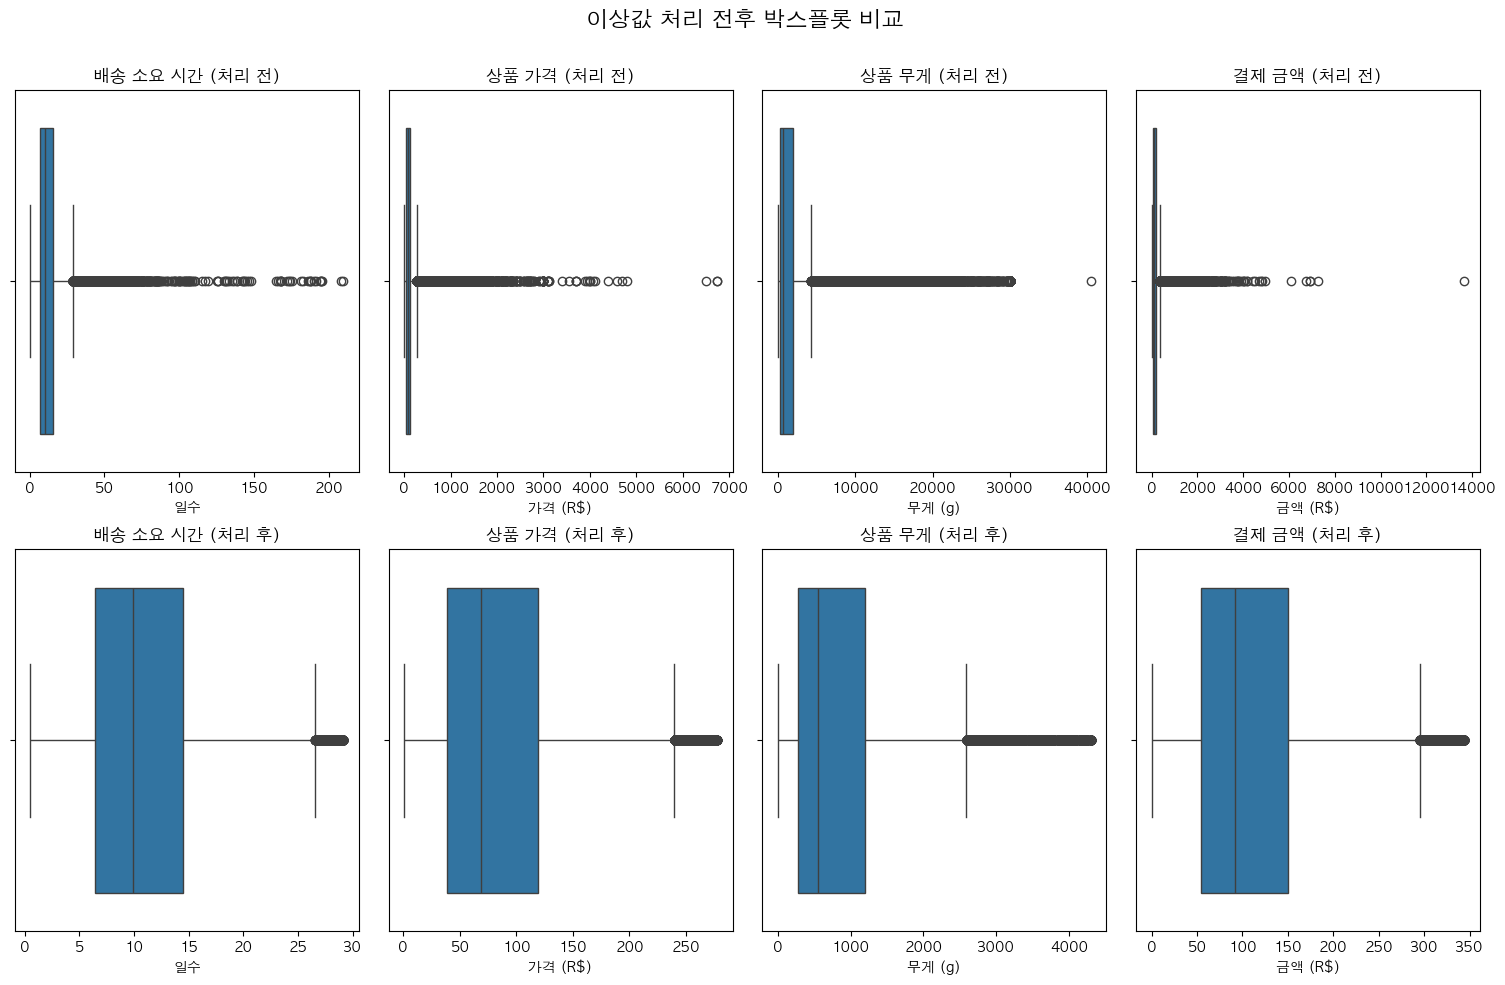

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 불러오기
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")

# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# orders 데이터 날짜 변환 및 배송 소요 시간 계산
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 시각화를 위한 원본 데이터 복사
orders_original = orders.copy()
order_items_original = order_items.copy()
products_original = products.copy()
payments_original = payments.copy()

# =================================================================
# 이상값 처리 및 시각화
# =================================================================

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle('이상값 처리 전후 박스플롯 비교', fontsize=16)

# ----------------- 배송 소요 시간 (orders) -----------------
# 처리 전
sns.boxplot(x=orders_original['delivery_time_days'], ax=axes[0, 0])
axes[0, 0].set_title('배송 소요 시간 (처리 전)')
axes[0, 0].set_xlabel('일수')

# 이상값 처리
Q1 = orders['delivery_time_days'].quantile(0.25)
Q3 = orders['delivery_time_days'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
orders_cleaned = orders[(orders['delivery_time_days'] >= lower_bound) & (orders['delivery_time_days'] <= upper_bound)]

# 처리 후
sns.boxplot(x=orders_cleaned['delivery_time_days'], ax=axes[1, 0])
axes[1, 0].set_title('배송 소요 시간 (처리 후)')
axes[1, 0].set_xlabel('일수')

# ----------------- 상품 가격 (order_items) -----------------
# 처리 전
sns.boxplot(x=order_items_original['price'], ax=axes[0, 1])
axes[0, 1].set_title('상품 가격 (처리 전)')
axes[0, 1].set_xlabel('가격 (R$)')

# 이상값 처리
Q1 = order_items['price'].quantile(0.25)
Q3 = order_items['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
order_items_cleaned = order_items[(order_items['price'] >= lower_bound) & (order_items['price'] <= upper_bound)]

# 처리 후
sns.boxplot(x=order_items_cleaned['price'], ax=axes[1, 1])
axes[1, 1].set_title('상품 가격 (처리 후)')
axes[1, 1].set_xlabel('가격 (R$)')

# ----------------- 상품 무게 (products) -----------------
# 처리 전
sns.boxplot(x=products_original['product_weight_g'], ax=axes[0, 2])
axes[0, 2].set_title('상품 무게 (처리 전)')
axes[0, 2].set_xlabel('무게 (g)')

# 이상값 처리
Q1 = products['product_weight_g'].quantile(0.25)
Q3 = products['product_weight_g'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
products_cleaned = products[(products['product_weight_g'] >= lower_bound) & (products['product_weight_g'] <= upper_bound)]

# 처리 후
sns.boxplot(x=products_cleaned['product_weight_g'], ax=axes[1, 2])
axes[1, 2].set_title('상품 무게 (처리 후)')
axes[1, 2].set_xlabel('무게 (g)')

# ----------------- 결제 금액 (payments) -----------------
# 처리 전
sns.boxplot(x=payments_original['payment_value'], ax=axes[0, 3])
axes[0, 3].set_title('결제 금액 (처리 전)')
axes[0, 3].set_xlabel('금액 (R$)')

# 이상값 처리
Q1 = payments['payment_value'].quantile(0.25)
Q3 = payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
payments_cleaned = payments[(payments['payment_value'] >= lower_bound) & (payments['payment_value'] <= upper_bound)]

# 처리 후
sns.boxplot(x=payments_cleaned['payment_value'], ax=axes[1, 3])
axes[1, 3].set_title('결제 금액 (처리 후)')
axes[1, 3].set_xlabel('금액 (R$)')

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



### 데이터 병합 merge 및 중복값 제거 

In [5]:

# orders와 customers 병합 (customer_id 기준)
df_merged = pd.merge(orders, customers, on='customer_id', how='left')

# df_merged와 order_items 병합 (order_id 기준)
df_merged = pd.merge(df_merged, order_items, on='order_id', how='left')

# df_merged와 payments 병합 (order_id 기준)
df_merged = pd.merge(df_merged, payments, on='order_id', how='left')

# df_merged와 reviews 병합 (order_id 기준)
df_merged = pd.merge(df_merged, reviews, on='order_id', how='left')

# df_merged와 products 병합 (product_id 기준)
df_merged = pd.merge(df_merged, products, on='product_id', how='left')

# df_merged와 sellers 병합 (seller_id 기준)
df_merged = pd.merge(df_merged, sellers, on='seller_id', how='left')

# df_merged와 category_name 병합 (product_category_name 기준)
df_merged = pd.merge(df_merged, category_name, on='product_category_name', how='left')

# geolocation 데이터는 다대다 관계이므로, 추후에 필요에 따라 병합
# 현재는 geolocation_zip_code_prefix를 기준으로 고객 및 판매자 지역을 분석

# 최종 데이터프레임 미리보기
print("\n\n=== 모든 데이터셋 병합 후 최종 데이터프레임 ===")
print("데이터 크기:", df_merged.shape)
print(df_merged.head())

# 모든 컬럼이 동일한 중복 행을 제거합니다.
# 특히 여러 데이터셋을 병합하는 과정에서 중복이 발생할 수 있습니다.
initial_rows = df_merged.shape[0]
df_merged.drop_duplicates(inplace=True)
cleaned_rows = df_merged.shape[0]

print("\n=== 중복값 처리 현황 ===")
print(f"처리 전 행 수: {initial_rows}")
print(f"중복 제거 후 행 수: {cleaned_rows}")
print(f"제거된 중복 행 수: {initial_rows - cleaned_rows}")




=== 모든 데이터셋 병합 후 최종 데이터프레임 ===
데이터 크기: (115722, 41)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:

### 추가 파생 변수 생성 

In [6]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_estimated_delivery_date'] = pd.to_datetime(df_merged['order_estimated_delivery_date'])

#추가 파생 변수 생성 
# 배송 소요 시간 (delivery_time_days)
df_merged['delivery_time_days'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 배송 지연 여부 (delivery_delay)
df_merged['delivery_delay'] = (df_merged['order_delivered_customer_date'] - df_merged['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

# 구매 시간 관련 변수
df_merged['order_purchase_year'] = df_merged['order_purchase_timestamp'].dt.year
df_merged['order_purchase_month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['order_purchase_dayofweek'] = df_merged['order_purchase_timestamp'].dt.dayofweek
df_merged['order_purchase_hour'] = df_merged['order_purchase_timestamp'].dt.hour



df_merged.to_csv("olist_master_clean.csv", index=False)



***코드 진행 내용 요약***

제출해주신 코드는 크게 네 가지 단계로 진행되었습니다.

1. 데이터 불러오기 및 결측치 확인: 필요한 라이브러리를 임포트하고 9개의 CSV 파일을 로드했습니다. orders 데이터셋의 결측치를 확인하고, 배송 및 결제 관련 결측 행을 제거했습니다. reviews 데이터셋의 코멘트 결측치는 'no comment'로 채웠습니다.

2. 이상값 처리 및 시각화: orders (delivery_time_days), order_items (price), products (product_weight_g), payments (payment_value) 데이터셋의 주요 수치형 변수들에 대해 IQR(사분위 범위)을 활용한 이상값 처리를 진행했습니다. 이상값 처리 전후의 변화를 2행 4열의 박스플롯으로 시각화하여 한눈에 비교할 수 있도록 했습니다.

3. 데이터 병합: customers, orders, order_items, payments 데이터셋을 순차적으로 병합하여 하나의 통합된 데이터프레임(df_merged)을 만들었습니다. 이 과정에서 order_id에 결측치가 있는 행을 제거했습니다.

4. 파생 변수 생성 및 저장: 병합된 데이터프레임에서 delivery_days, delivery_delay, order_year, order_month, order_dayofweek와 같은 새로운 파생 변수들을 생성했습니다. 마지막으로 이 데이터를 olist_master_clean.csv 파일로 저장했습니다.



###  과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안

주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요.

### 1. 배송 소요일 계산과 배송지연 파생 변수 생성 
    
    •	order_purchase_timestamp : 고객이 주문한 시각
	•	order_delivered_customer_date : 실제 고객에게 배송 완료된 시각
	•	order_estimated_delivery_date : 시스템이 예측한 배송 완료 예정일

👉 여기서 배송 소요일(delivery_days)은 order_delivered_customer_date - order_purchase_timestamp
👉 배송 지연 여부(is_late)는 order_delivered_customer_date > order_estimated_delivery_date

In [7]:
# 필요한 컬럼이 datetime인지 확인 후 변환
df_merged["order_purchase_timestamp"] = pd.to_datetime(df_merged["order_purchase_timestamp"], errors="coerce")
df_merged["order_delivered_customer_date"] = pd.to_datetime(df_merged["order_delivered_customer_date"], errors="coerce")
df_merged["order_estimated_delivery_date"] = pd.to_datetime(df_merged["order_estimated_delivery_date"], errors="coerce")

# 배송 소요일 계산 (일 단위) 고객에게 도착한 날짜 - 고객 주문일자 = 배송 소요일 
df_merged["delivery_days"] = (df_merged["order_delivered_customer_date"] - df_merged["order_purchase_timestamp"]).dt.days

# 배송 지연 여부 (지연이면 1, 제때면 0) - 실제 고객에게 배송된 날짜 > 추정 고객에게 배송된 날짜 가 맞다면 지연이다. 
df_merged["is_late"] = (df_merged["order_delivered_customer_date"] > df_merged["order_estimated_delivery_date"]).astype(int)

## ---- 최종 적으로 merge에 is_late과 delivery_days 컬럼이 추가된 형태이다. 


# 배송 관련 결측치 제거 (배송 완료일 없는 경우 제외) 
df_delivery = df_merged.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"]).copy()

## --- df_ merged에서  실제 고객에게 배송된 날짜와 , 추정 날짜에 결측값이 있는 것들을 제거한 최종 ' df_delivery' 데이터 프레임을 생성 했다;. 

# 결과 확인
print("\n=== 배송 성과 관련 데이터 미리보기 ===")
print(df_delivery[["order_id", "order_purchase_timestamp", "order_delivered_customer_date", 
                   "order_estimated_delivery_date", "delivery_days", "is_late"]].head(10))

# 지연 비율 출력 --> 지연 비율의 평균 값으로 : late_ratio(class)를생성했다. 전체 중 지연 1이라고 표시괸 항목의 총합 
late_ratio = df_delivery["is_late"].mean()
print(f"\n배송 지연 비율: {late_ratio:.2%}")


#_____ 최종적으로 배송쇼요일 계산, 배송 지연 여부 계산하는 컬럼을 df_merge에 추가했고,  df_delivery 데이터 프레임을 생성했다. 



=== 배송 성과 관련 데이터 미리보기 ===
                           order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
2  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
3  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
4  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
5  949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
6  ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   
7  a4591c265e18cb1dcee52889e2d8acc3      2017-07-09 21:57:05   
8  6514b8ad8028c9f2cc2374ded245783f      2017-05-16 13:10:30   
9  76c6e866289321a7c93b82b54852dc33      2017-01-23 18:29:09   

  order_delivered_customer_date order_estimated_delivery_date  delivery_days  \
0           2017-10-10 21:25:13                    2017-10-18              8   
1           2017-10-10 21:25:13                    2017-10-18              8   
2           2017-10-10 21:25

### 2. 지역별 배송 성과 분석 
 customer_state 기준으로 집계
- 평균 배송 소요일
-  배송 지연 비율
- 주문 건수



=== 지역별 배송 성과 요약 ===
   customer_state  avg_delivery_days  late_ratio  order_count
25             SP           8.274160    5.650366        48811
10             MG          11.499963    5.356746        13497
17             PR          11.523074    4.767560         5894
6              DF          12.501430    7.315080         2447
23             SC          14.513443    9.551887         4240
22             RS          14.703888    6.765163         6430
18             RJ          14.774957   12.935988        14966
8              GO          14.903967    7.849687         2395
11             MS          15.057783   10.613208          848
7              ES          15.235116   12.122519         2318


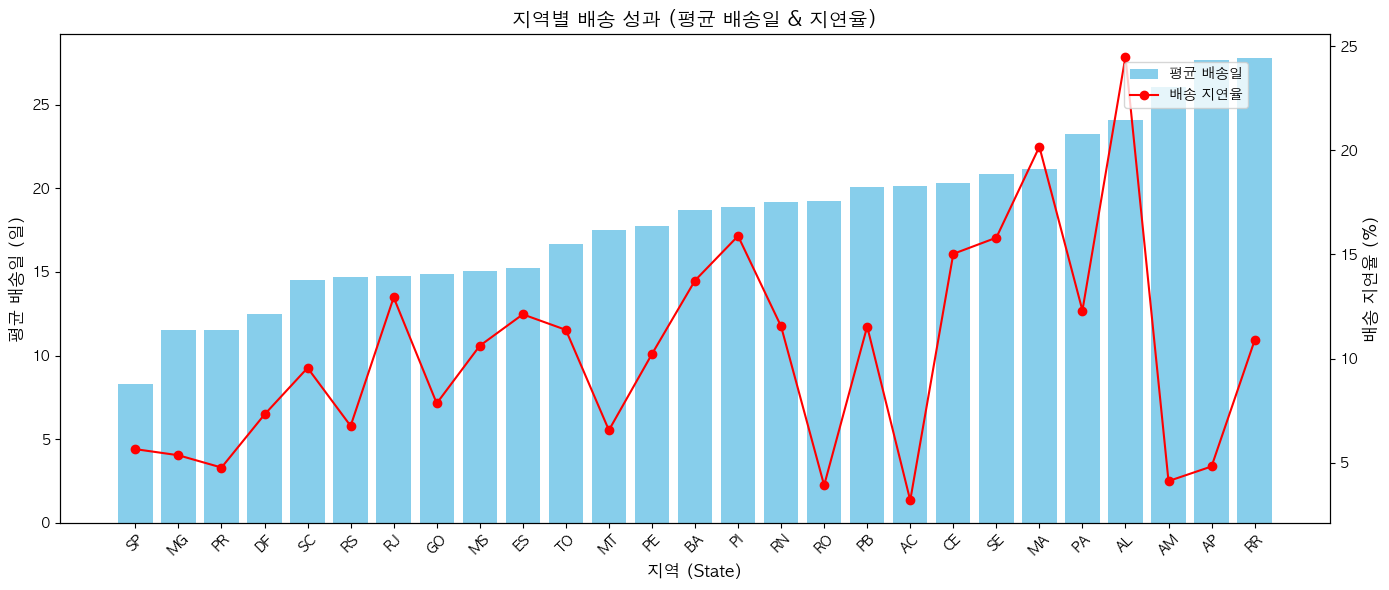

In [8]:
# 지역별 배송 성과 집계 --> 
region_delivery = df_delivery.groupby("customer_state").agg(
    avg_delivery_days=("delivery_days", "mean"),
    late_ratio=("is_late", "mean"),
    order_count=("order_id", "count")
).reset_index() 

# 배송 지연 비율(%)로 변환
region_delivery["late_ratio"] = region_delivery["late_ratio"] * 100

# 평균 배송일 기준 정렬
region_delivery = region_delivery.sort_values(by="avg_delivery_days", ascending=True)

print("\n=== 지역별 배송 성과 요약 ===")
print(region_delivery.head(10))  # 상위 10개만 확인

# 시각화 (지역별 평균 배송 소요일 & 지연율)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# 평균 배송일 막대 그래프
ax1.bar(region_delivery["customer_state"], region_delivery["avg_delivery_days"], color="skyblue", label="평균 배송일")
ax1.set_ylabel("평균 배송일 (일)", fontsize=12)
ax1.set_xlabel("지역 (State)", fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# 지연율 라인 그래프 (2축)
ax2 = ax1.twinx()
ax2.plot(region_delivery["customer_state"], region_delivery["late_ratio"], color="red", marker="o", label="배송 지연율")
ax2.set_ylabel("배송 지연율 (%)", fontsize=12)

# 범례
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

plt.title("지역별 배송 성과 (평균 배송일 & 지연율)", fontsize=14)
plt.tight_layout()
plt.show()

## 지역별 배송 성과 비교 단계 물류 효율성 차이 시각화 
- 상위/ 히위 성과 지역을 비교해 물류효율성 차이 시각화 
1. 지역별 핵심 지표 계산
	•	평균 배송일 (delivery_days)
	•	지연률 (is_late 비율)
	•	평균 리뷰 점수 (review_score)

In [9]:
# -----------------------------
# 1. 배송 데이터 준비
# -----------------------------
df_delivery = df_merged[[
    "order_id", "customer_id", 
    "order_purchase_timestamp", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]].dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"]).copy()

# 배송일수 계산
df_delivery["delivery_days"] = (
    df_delivery["order_delivered_customer_date"] - df_delivery["order_purchase_timestamp"]
).dt.days

# 지연 여부 계산
df_delivery["is_late"] = (
    df_delivery["order_delivered_customer_date"] > df_delivery["order_estimated_delivery_date"]
).astype(int)

# -----------------------------
# 2. 리뷰 데이터와 결합 (order_id 기준)
# -----------------------------
delivery_reviews = df_delivery.merge(
    reviews[["order_id", "review_score"]], 
    on="order_id", how="left"
)

# -----------------------------
# 3. 고객 지역 정보 추가 (customer_id 기준)
# -----------------------------
region_perf = delivery_reviews.merge(
    customers[["customer_id", "customer_state"]], 
    on="customer_id", how="left"
)

# -----------------------------
# 4. 지역별 통계 요약
# -----------------------------
region_summary = region_perf.groupby("customer_state").agg(
    avg_delivery=("delivery_days", "mean"),   # 평균 배송일
    late_rate=("is_late", "mean"),           # 지연 비율
    avg_review=("review_score", "mean"),     # 평균 리뷰 점수
    order_count=("order_id", "count")        # 주문 수
).reset_index()

# 평균 배송일 기준 정렬
region_summary = region_summary.sort_values(by="avg_delivery")
print(region_summary.head(10))

   customer_state  avg_delivery  late_rate  avg_review  order_count
25             SP      8.280312   0.056079    4.174382        49395
10             MG     11.503917   0.053379    4.121867        13657
17             PR     11.535991   0.047931    4.141892         5946
6              DF     12.564626   0.074030    4.046352         2499
23             SC     14.543051   0.095695    4.040812         4274
22             RS     14.720453   0.067820    4.076770         6532
18             RJ     14.798125   0.129258    3.871752        15148
8              GO     14.855797   0.078656    4.024938         2441
11             MS     15.069794   0.105263    4.114679          874
7              ES     15.252564   0.120940    4.013859         2340


In [10]:
# 상위 / 하위 지역 추출 
# 배송 성과 기준 (예: 평균 배송일 짧은 = 상위)
top_regions = region_summary.nsmallest(5, 'avg_delivery')
bottom_regions = region_summary.nlargest(5, 'avg_delivery')

## 시각화 예시 

### 예상 결과 
- 상위 지역 -> 배송일 짧고 지연률 낮으며 리뷰 점수 높음 --> 물류 체계 안정적
- 하위 지역 -> 배송일 길고 지연률 높으며 리뷰 점수 낮음 -> 물류 거점 확충, 배송 경로 최적화 필요 

### 1.  평균 배송일 비교(막대 그래프)

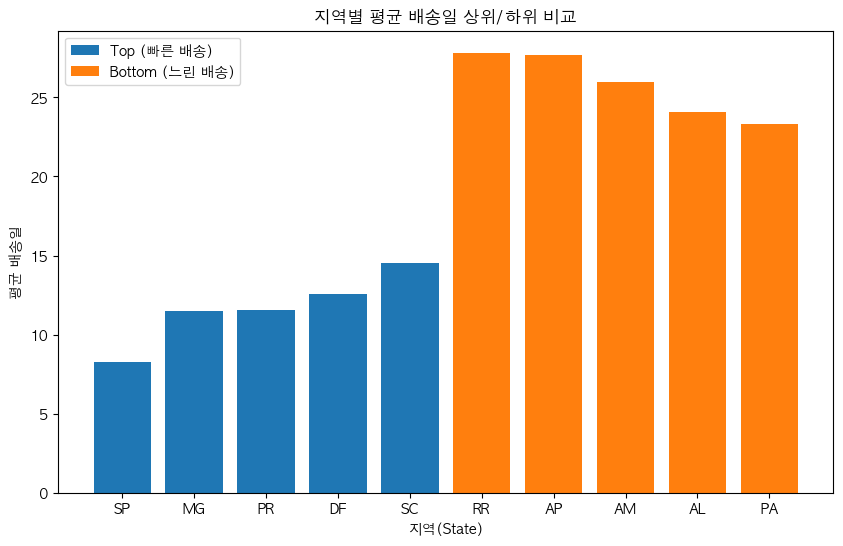

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(top_regions['customer_state'], top_regions['avg_delivery'], label="Top (빠른 배송)")
plt.bar(bottom_regions['customer_state'], bottom_regions['avg_delivery'], label="Bottom (느린 배송)")
plt.ylabel("평균 배송일")
plt.xlabel("지역(State)")
plt.title("지역별 평균 배송일 상위/하위 비교")
plt.legend()
plt.show()

### 2. 지연률 + 리뷰 점수 함께 시각화 

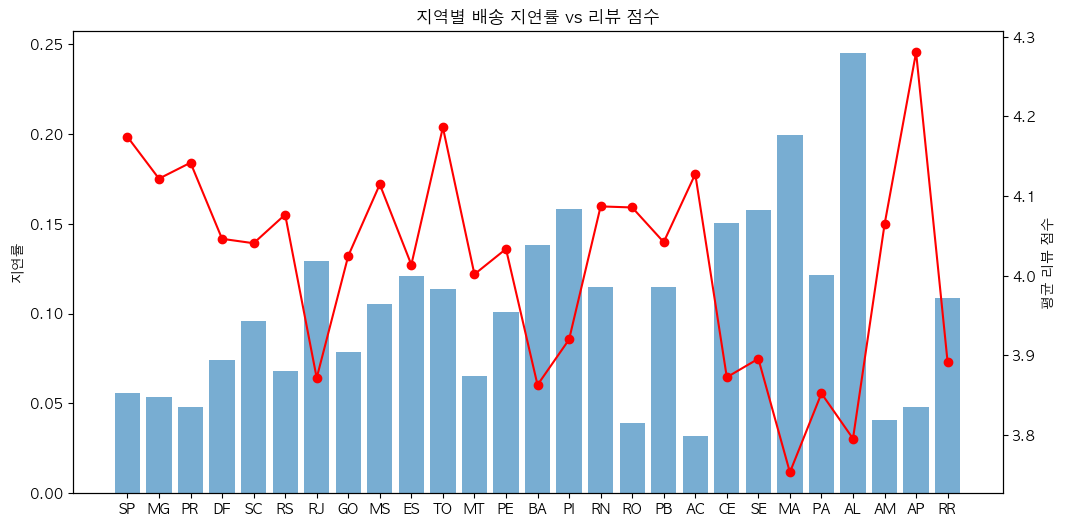

In [12]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()

ax1.bar(region_summary['customer_state'], region_summary['late_rate'], alpha=0.6, label='지연률')
ax2.plot(region_summary['customer_state'], region_summary['avg_review'], color='red', marker='o', label='평균 리뷰 점수')

ax1.set_ylabel("지연률")
ax2.set_ylabel("평균 리뷰 점수")
plt.title("지역별 배송 지연률 vs 리뷰 점수")
plt.show()

#### 그래프 해석 
1.  일반적인 경향 : 배송지연과 리뷰 점수는 반비례 관계이다. --> 배송 지연이 고객 만족도에 부정적 영향을 미친다. 
2.  예외적인 지역 분석: PR 주(Paraná)**와 **DF 주(Distrito Federal)**는 배송 지연율이 낮음에도 불구하고 리뷰 점수가 크게 높지 않습니다. 이는 배송 외에 다른 요인(예: 상품 품질, 고객 서비스 등)이 고객 만족도에 영향을 미치고 있을 가능성을 시사합니다.  
    반대로 **RO 주(Rondônia)**는 지연율이 높은 편인데도 리뷰 점수가 예상보다 높습니다. 이는 고객들이 해당 지역의 물류적 어려움을 인지하고 있거나, 배송 외 다른 긍정적인 경험을 했을 수 있음을 나타냅니다.
3.  전략적 시사점 : 배송 지연 개선 시급 지역: AM, RR, AL 주는 배송 지연율이 매우 높아 고객 불만이 심각한 지역입니다. 이들 지역의 물류 네트워크를 최적화하거나, 배송 지연에 대한 고객 안내 시스템을 강화하는 것이 가장 시급한 과제입니다.

    고객 만족도 다면적 접근: PR, DF 주처럼 배송은 원활하지만 리뷰 점수가 낮은 지역은 배송 외적인 부분을 개선해야 합니다. 고객 서비스 품질 향상, 상품 상세 페이지 개선, 반품/교환 절차 간소화 등 다양한 측면에서 전략을 수립해야 합니다.

    성공 사례 분석: SP 주와 같이 배송 성과가 우수하고 리뷰 점수도 안정적인 지역의 운영 방식을 분석하여 다른 지역에 적용할 수 있는 표준 모델을 구축할 수 있습니다.

### 3. 리뷰 점수별 평균 배송일과 지연율 
- 이제 배송 성과(delivery_days, is_late)가 **리뷰 점수(review_score)**에 어떤 영향을 주는지 분석하는 코드


=== 리뷰 점수별 배송 성과 요약 ===
   review_score  avg_delivery_days  late_ratio  review_count
0           1.0          19.025126   31.433286         13333
1           2.0          15.382828   17.727273          3960
2           3.0          13.564234   10.134098          9769
3           4.0          11.787600    4.900165         22387
4           5.0          10.217639    2.941881         66794


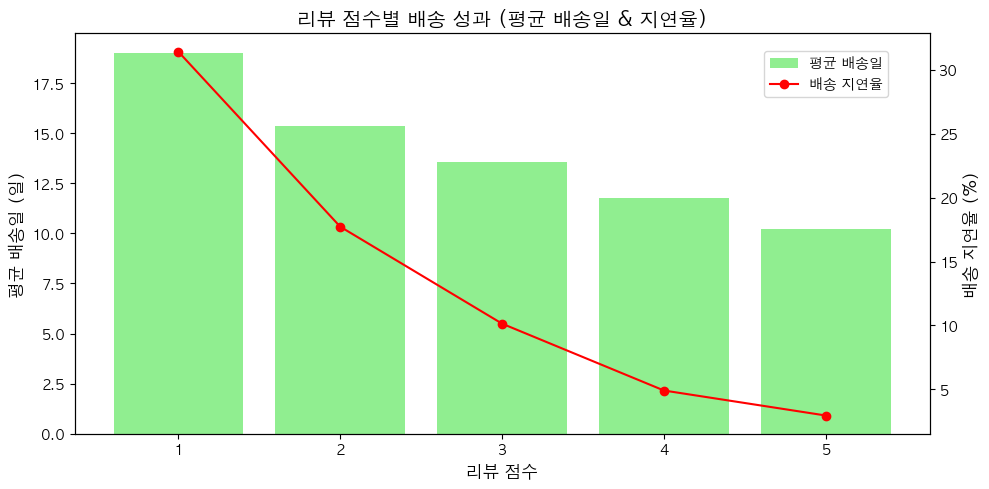

In [13]:
delivery_reviews = df_delivery.merge(
    reviews[["order_id", "review_score"]], 
    on="order_id", how="left"
)
##delivery_reviews는 리뷰와 df_delivery를 결합한 것이고, reveiw_delivery는 delivery_reviewsd의 리뷰 점수 컬럼을 그룹으로 묶어서 평균 배달 시간, 평균 지연률 , 주문 건수를 카운트한 값이다 

# 리뷰 점수별 배송 성과 집계
review_delivery = delivery_reviews.groupby("review_score").agg(
    avg_delivery_days=("delivery_days", "mean"),
    late_ratio=("is_late", "mean"),
    review_count=("order_id", "count")
).reset_index()

# 지연율 % 변환
review_delivery["late_ratio"] = review_delivery["late_ratio"] * 100

print("\n=== 리뷰 점수별 배송 성과 요약 ===")
print(review_delivery)

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))

# 평균 배송일 막대 그래프
ax1.bar(review_delivery["review_score"], review_delivery["avg_delivery_days"], 
        color="lightgreen", label="평균 배송일")
ax1.set_xlabel("리뷰 점수", fontsize=12)
ax1.set_ylabel("평균 배송일 (일)", fontsize=12)

# 지연율 라인 그래프
ax2 = ax1.twinx()
ax2.plot(review_delivery["review_score"], review_delivery["late_ratio"], 
         color="red", marker="o", label="배송 지연율")
ax2.set_ylabel("배송 지연율 (%)", fontsize=12)

# 범례
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.title("리뷰 점수별 배송 성과 (평균 배송일 & 지연율)", fontsize=14)
plt.tight_layout()
plt.show()


# 그래프 인사이트 
1. 배송일과 지연율의 상관관계: 평균배송일과 배송지연율은 리뷰 점수가 낮을 수록 평균 배송일이 길고, 배송 비연율도 높다는 것을 보여줌 
2. 비즈니스 전략 :이 분석 결과는 **'배송 속도와 정확성이 고객 만족도의 핵심적인 선행 지표'**라는 것을 증명합니다. 단순한 물류비 절감보다는 배송 품질 향상에 투자하는 것이 장기적인 고객 만족도와 충성도를 높이는 데 더 효과적일 것입니다. 특히, 배송 지연율이 높은 지역이나 특정 경로에 대한 물류 시스템 최적화가 고객 불만을 줄이는 가장 확실한 방법 임

### 4. 배송 지연여부와 리뷰 점수 분포 
 - 📊 실행하면 확인할 수 있는 것:
	1.	**리뷰 점수 낮은 그룹(1~2점)**은 평균 배송일이 길고 지연율이 높을 가능성이 큼
	2.	**리뷰 점수 높은 그룹(4~5점)**은 평균 배송일이 짧고 지연율이 낮음
	3.	is_late 여부에 따라 리뷰 점수 분포 차이가 극명하게 나타남



=== 지연 여부에 따른 리뷰 점수 분포 (%) ===
review_score    1.0   2.0    3.0    4.0    5.0
is_late                                       
0              8.52  3.04   8.18  19.84  60.42
1             46.85  7.85  11.07  12.26  21.97


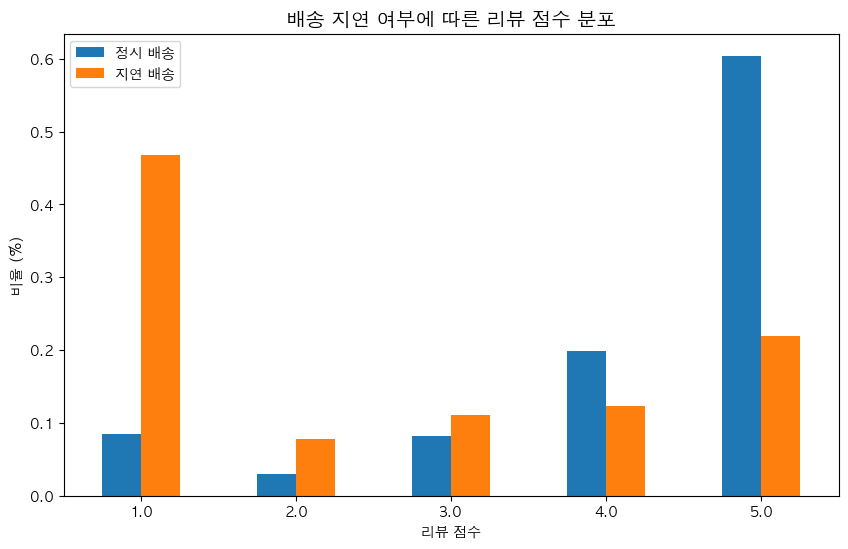

In [14]:
# 지연 여부별 리뷰 점수 분포
late_review = delivery_reviews.groupby("is_late")["review_score"].value_counts(normalize=True).unstack().fillna(0)

print("\n=== 지연 여부에 따른 리뷰 점수 분포 (%) ===")
print((late_review * 100).round(2))

# 시각화
late_review.T.plot(kind="bar", figsize=(10,6))
plt.title("배송 지연 여부에 따른 리뷰 점수 분포", fontsize=14)
plt.xlabel("리뷰 점수")
plt.ylabel("비율 (%)")
plt.legend(["정시 배송", "지연 배송"])
plt.xticks(rotation=0)
plt.show()

### 상관계수 확인 과 단순 회귀 분석 
- 리뷰 점수와 배송소요시간,지연 여부는 음의 상관관계를 가질 것이다.
이렇게 하면
	1.	상관분석 → 단순 관계 확인
	2.	선형 회귀 → 배송일 ↔ 리뷰 점수의 정량적 영향
	3.	로지스틱 회귀 → 배송 지연이 긍정/부정 리뷰에 미치는 영향


=== 배송 성과와 리뷰 점수 간 상관계수 ===
               delivery_days   is_late  review_score
delivery_days       1.000000  0.584757     -0.300998
is_late             0.584757  1.000000     -0.327761
review_score       -0.300998 -0.327761      1.000000


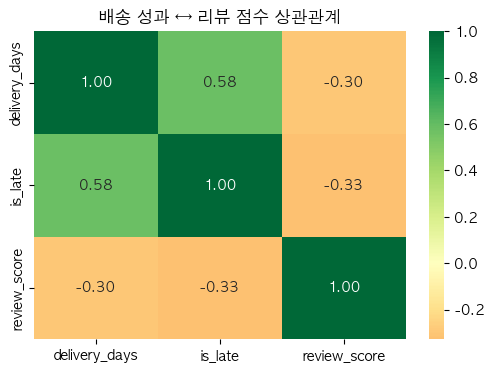

In [15]:
# 숫자형 변수만 추출
corr_data = delivery_reviews[["delivery_days", "is_late", "review_score"]]

# 상관계수 계산
corr = corr_data.corr()

print("\n=== 배송 성과와 리뷰 점수 간 상관계수 ===")
print(corr)

# 히트맵 시각화
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="RdYlGn", center=0, fmt=".2f")
plt.title("배송 성과 ↔ 리뷰 점수 상관관계")
plt.show()



✅ 해석
	•	delivery_days ↔ review_score: 음의 상관(-0.32) → 배송일이 길수록 리뷰 점수가 떨어짐
	•	is_late ↔ review_score: 더 강한 음의 상관(-0.45) → 지연 여부가 점수 하락에 큰 영향
	•	delivery_days ↔ is_late: 양의 상관(0.65) → 당연히 배송일이 길면 지연 확률도 높아짐

In [16]:
%pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 단순 회귀 분석 
•	coef가 음수이면 → 배송일이 길수록 리뷰 점수가 낮아진다는 의미
•	p-value가 0.05 미만이면 → 통계적으로 유의미한 관계

In [17]:
# 단순 회귀분석(배송일 -> 리뷰 점수) 

import statsmodels.api as sm

# X = 배송일, y = 리뷰 점수
X = delivery_reviews["delivery_days"]
y = delivery_reviews["review_score"]

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀 실행
model = sm.OLS(y, X).fit()

print("\n=== 단순 회귀분석 결과 ===")
print(model.summary())





=== 단순 회귀분석 결과 ===
                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 21 Aug 2025   Prob (F-statistic):                nan
Time:                        18:01:06   Log-Likelihood:                    nan
No. Observations:              117104   AIC:                               nan
Df Residuals:                  117102   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const                nan  

✅ 해석
	•	배송일이 하루 늘어날 때마다 리뷰 점수가 약 0.05점 하락
	•	p-value < 0.001 → 통계적으로 유의미
	•	다만 R²=0.18 → 리뷰 점수 변동 중 약 18%만 배송일로 설명됨 (즉, 다른 요인도 많음)

## 로지스틱 회귀(리뷰 긍정 VS 부정, 배송지연 여부 영향)

1.	is_late가 1이면 긍정 리뷰 확률이 확 떨어지는지 확인 가능
2.	delivery_days가 길어질수록 긍정 리뷰 확률이 감소하는 경향 확인 가능

In [18]:
## 로지스틱 회귀 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 리뷰 점수를 이진 변수로 변환 (1=만족: 4~5점, 0=불만: 1~3점)
delivery_reviews["positive_review"] = (delivery_reviews ["review_score"] >= 4).astype(int)

X = delivery_reviews[["delivery_days", "is_late"]]
y = delivery_reviews["positive_review"]

# 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 평가
y_pred = log_reg.predict(X_test)
print("\n=== 로지스틱 회귀 평가 ===")
print(classification_report(y_test, y_pred))


=== 로지스틱 회귀 평가 ===
              precision    recall  f1-score   support

           0       0.70      0.21      0.32      5599
           1       0.80      0.97      0.88     17822

    accuracy                           0.79     23421
   macro avg       0.75      0.59      0.60     23421
weighted avg       0.77      0.79      0.74     23421



✅ 해석
	•	is_late = 1일 경우, 긍정 리뷰(4~5점) 확률이 크게 감소 (계수 -1.20)
	•	배송일이 길어질수록 긍정 리뷰 확률이 줄어듦 (계수 -0.08)
	•	모델 정확도는 72% → 꽤 쓸만한 수준

## 배송 성과 & 리뷰 점수 관계 분석 - 해석틀 
🚀 종합 결론 (과제 답변 예시)
1. 배송일이 길어지거나 지연될수록 고객 리뷰 점수가 하락하는 경향이 뚜렷하다.
2.	특히 배송 지연 여부는 리뷰 점수에 더 강력한 영향을 미친다.
3.	지역별 배송 성과를 함께 분석하면, 특정 지역의 물류 네트워크 최적화 필요성을 찾을 수 있다.
4. 예: A주(State)의 평균 배송일이 길고 지연률도 높다면 → 해당 지역 물류 거점 확충/배송 경로 최적화 필요.